<h1 style="font-size:32px; text-align:center;">Projet Scoring</h1>
<hr>
<h1 style="font-size:18px; text-align:center; margin-bottom:24px;">Ousmane KA</h1>
<hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno
from skimpy import skim
import warnings
import os
import itertools
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from scipy.stats import skew
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency, mannwhitneyu
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./Dataset/hmeq.csv')

<span style="color:#0A8791; font-size:24px;"><b><u>Traitement méticuleuse des données</u></b></span>

In [3]:
# Identifier les lignes où MORTDUE est supérieur à VALUE
mortdue_value_issues = df[df["MORTDUE"] > df["VALUE"]]

# Compter le nombre de cas où MORTDUE > VALUE
num_mortdue_value_issues = mortdue_value_issues.shape[0]

# Afficher un échantillon de ces cas problématiques
sample_issues = mortdue_value_issues[["MORTDUE", "VALUE"]].head(10)

# Afficher les résultats
print(f"Nombre de cas où MORTDUE > VALUE: {num_mortdue_value_issues}")
print(sample_issues)


Nombre de cas où MORTDUE > VALUE: 51
     MORTDUE    VALUE
1    70053.0  68400.0
50   39589.0  36100.0
94   64240.0  63990.0
136  25597.0  23031.0
184  40000.0  32480.0
216  40564.0  39527.0
218  66987.0  65111.0
252  72147.0  69918.0
339  68743.0  65321.0
457  53776.0  51952.0


In [4]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [5]:
from sklearn.linear_model import LinearRegression

def handle_missing_values(df):
    # Étape 1 : Gestion des valeurs manquantes dans la colonne 'VALUE' (Valeur de la propriété)
    print(f"Valeurs manquantes dans 'VALUE' : {df['VALUE'].isnull().sum()} valeurs")
    
    # Étape 1a : Prédire 'VALUE' en fonction du ratio médian LOAN-to-VALUE
    df['loan_to_value'] = df['VALUE'] / df['LOAN']
    median_ratio = df['loan_to_value'].median()
    print(f"Ratio médian LOAN-to-VALUE : {median_ratio}")
    
    # Remplacer les valeurs manquantes de 'VALUE' par LOAN * ratio_médian
    df.loc[df['VALUE'].isnull(), 'VALUE'] = df.loc[df['VALUE'].isnull(), 'LOAN'] * median_ratio
    
    # Étape 1b : Vérification de la cohérence, la valeur de 'VALUE' ne doit pas être inférieure à 'MORTDUE'
    df['VALUE'] = df[['VALUE', 'MORTDUE']].max(axis=1)

    # Étape 1c : Imputation des valeurs restantes par la médiane dans les plages de LOAN
    df['loan_range'] = (df['LOAN'] // 5000) * 5000
    for loan_range, group in df.groupby('loan_range'):
        median_value = group['VALUE'].median()
        df.loc[(df['VALUE'].isnull()) & (df['loan_range'] == loan_range), 'VALUE'] = median_value
    
    # Étape 1d : Si aucune correspondance, utiliser la médiane globale pour 'VALUE'
    df['VALUE'].fillna(df['VALUE'].median(), inplace=True)
    
    # Vérification de la cohérence des valeurs 'VALUE'
    df = df[df['VALUE'] >= 0]

    # Étape 2 : Gestion des valeurs manquantes dans 'MORTDUE' (Montant du prêt restant)
    print(f"Valeurs manquantes dans 'MORTDUE' : {df['MORTDUE'].isnull().sum()} valeurs")

    # Étape 2a : Prédire 'MORTDUE' en fonction du ratio médian MORTDUE-to-VALUE
    df['ltv_ratio'] = df['MORTDUE'] / df['VALUE']
    median_ltv_ratio = df['ltv_ratio'].median()
    print(f"Ratio médian MORTDUE-to-VALUE : {median_ltv_ratio}")
    
    # Remplacer les valeurs manquantes de 'MORTDUE' par VALUE * ratio_médian
    df.loc[df['MORTDUE'].isnull(), 'MORTDUE'] = df.loc[df['MORTDUE'].isnull(), 'VALUE'] * median_ltv_ratio
    
    # Étape 2b : Vérification de la cohérence, MORTDUE ne doit pas dépasser VALUE
    df['MORTDUE'] = df[['MORTDUE', 'VALUE']].min(axis=1)

    # Étape 2c : Imputation des valeurs restantes par la médiane dans les plages de VALUE
    df['value_range'] = (df['VALUE'] // 5000) * 5000
    for value_range, group in df.groupby('value_range'):
        median_mortdue = group['MORTDUE'].median()
        df.loc[(df['MORTDUE'].isnull()) & (df['value_range'] == value_range), 'MORTDUE'] = median_mortdue

    # Étape 2d : Si aucune correspondance, utiliser la médiane globale pour 'MORTDUE'
    df['MORTDUE'].fillna(df['MORTDUE'].median(), inplace=True)
    
    # Vérification de la cohérence des valeurs 'MORTDUE'
    df = df[df['MORTDUE'] >= 0]
    
    # Étape 3 : Cas limite et nettoyage final
    # Supprimer les lignes où à la fois 'VALUE' et 'MORTDUE' sont manquants
    df.dropna(subset=['VALUE', 'MORTDUE'], how='all', inplace=True)
    
    # Vérification finale de la cohérence (MORTDUE ne doit pas dépasser VALUE)
    df['MORTDUE'] = df[['MORTDUE', 'VALUE']].min(axis=1)

    return df

# Appliquer la fonction sur le DataFrame
df_cleaned = handle_missing_values(df)

Valeurs manquantes dans 'VALUE' : 112 valeurs
Ratio médian LOAN-to-VALUE : 5.864180035650624
Valeurs manquantes dans 'MORTDUE' : 518 valeurs
Ratio médian MORTDUE-to-VALUE : 0.7182660906635383


In [6]:
# Afficher uniquement les colonnes mortdue et valeur et vérifier si les valeurs manquantes sont supprimées.
ok = df_cleaned[['MORTDUE', 'VALUE']]
ok

,MORTDUE,VALUE
0,25860.000000,39025.000000
1,70053.000000,70053.000000
2,13500.000000,16700.000000
3,6318.062504,8796.270053
4,97800.000000,112000.000000
...,...,...
5955,57264.000000,90185.000000
5956,54576.000000,92937.000000
5957,54045.000000,92924.000000
5958,50370.000000,91861.000000


In [7]:
# vérifier les valeurs manquantes
df_cleaned.isnull().sum()

BAD                 0
LOAN                0
MORTDUE             0
VALUE               0
REASON            252
JOB               279
YOJ               515
DEROG             708
DELINQ            580
CLAGE             308
NINQ              510
CLNO              222
DEBTINC          1267
loan_to_value     112
loan_range          0
ltv_ratio         518
value_range         0
dtype: int64

In [8]:
# Vérifiez les valeurs NaN
df_cleaned.isna().sum()

BAD                 0
LOAN                0
MORTDUE             0
VALUE               0
REASON            252
JOB               279
YOJ               515
DEROG             708
DELINQ            580
CLAGE             308
NINQ              510
CLNO              222
DEBTINC          1267
loan_to_value     112
loan_range          0
ltv_ratio         518
value_range         0
dtype: int64

In [9]:
# Identifier les lignes où MORTDUE est supérieur à VALUE dans le dataframe nettoyé
mortdue_value_issues = df_cleaned[df_cleaned["MORTDUE"] > df_cleaned["VALUE"]]

# Compter le nombre de cas où MORTDUE > VALUE
num_mortdue_value_issues = mortdue_value_issues.shape[0]

# Afficher un échantillon de ces cas problématiques
sample_issues = mortdue_value_issues[["MORTDUE", "VALUE"]].head(10)

# Afficher les résultats
print(f"Nombre de cas où MORTDUE > VALUE: {num_mortdue_value_issues}")
print(sample_issues)


Nombre de cas où MORTDUE > VALUE: 0
Empty DataFrame
Columns: [MORTDUE, VALUE]
Index: []


In [10]:
df_cleaned.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,loan_to_value,loan_range,ltv_ratio,value_range
0,1,1100,25860.000000,39025.000000,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN,35.477273,0,0.662652,35000.0
1,1,1300,70053.000000,70053.000000,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN,52.615385,0,1.000000,70000.0
2,1,1500,13500.000000,16700.000000,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN,11.133333,0,0.808383,15000.0
3,1,1500,6318.062504,8796.270053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,5000.0
4,0,1700,97800.000000,112000.000000,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN,65.882353,0,0.873214,110000.0


In [11]:
def round_uncommon_loan(value):
    if value % 100 != 0:  # Si ce n'est pas un multiple de 100, on arrondit
        return round(value, -2)  # Arrondi à la centaine la plus proche
    return value  # Sinon, on garde la valeur originale

df_cleaned['LOAN'] = df_cleaned['LOAN'].apply(round_uncommon_loan)


In [12]:
df_cleaned['LOAN_VALID'] = df_cleaned['LOAN'] <= df_cleaned['VALUE']


In [13]:
# afficher les loans invalides
invalid_loans = df_cleaned[~df_cleaned['LOAN_VALID']]
print(invalid_loans)
# Supprimer les prêts invalides
df_cleaned = df_cleaned[df_cleaned['LOAN_VALID']]


      BAD   LOAN  MORTDUE    VALUE   REASON    JOB   YOJ  DEROG  DELINQ  \
5777    1  46300  39800.0  41600.0  DebtCon  Other   NaN    0.0     0.0   
5948    0  86000  47355.0  85000.0  DebtCon  Other  15.0    0.0     0.0   
5950    0  87500  55938.0  86794.0  DebtCon  Other  15.0    0.0     0.0   
5959    0  89900  48811.0  88934.0  DebtCon  Other  15.0    0.0     0.0   

           CLAGE  NINQ  CLNO    DEBTINC  loan_to_value  loan_range  ltv_ratio  \
5777  111.600000   1.0   3.0        NaN       0.898488       45000   0.956731   
5948  210.966667   0.0  16.0        NaN       0.988372       85000   0.557118   
5950  223.881040   0.0  16.0  36.753653       0.991931       85000   0.644492   
5959  219.601002   0.0  16.0  34.571519       0.989255       85000   0.548845   

      value_range  LOAN_VALID  
5777      40000.0       False  
5948      85000.0       False  
5950      85000.0       False  
5959      85000.0       False  


In [14]:
invalid_loans = df_cleaned[~df_cleaned['LOAN_VALID']]
print(invalid_loans)

Empty DataFrame
Columns: [BAD, LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC, loan_to_value, loan_range, ltv_ratio, value_range, LOAN_VALID]
Index: []


In [15]:
# Convertir en entier puis en float pour garantir l'affichage avec .0 sans décimales inutiles
df_cleaned['VALUE'] = df_cleaned['VALUE'].astype(int).astype(float)
df_cleaned['MORTDUE'] = df_cleaned['MORTDUE'].astype(int).astype(float)


In [16]:
# Gestion des valeurs manquantes pour 'DEBTINC' (ratio de la dette sur le revenu) - Numérique
print("Traitement des valeurs manquantes pour 'DEBTINC'.")
if df_cleaned['DEBTINC'].isnull().sum() > 0:  # Vérifier s'il y a des valeurs manquantes dans la colonne 'DEBTINC'
    
    model_debtinc = LinearRegression()  # Initialiser le modèle de régression linéaire
    df_debtinc_missing = df_cleaned[df_cleaned['DEBTINC'].isnull()]  # Extraire les lignes avec des valeurs manquantes dans 'DEBTINC'
    df_debtinc_notnull = df_cleaned[df_cleaned['DEBTINC'].notnull()]  # Extraire les lignes avec des valeurs non manquantes dans 'DEBTINC'
    
    # Entraîner le modèle sur les données disponibles (en utilisant 'LOAN' et 'MORTDUE' comme variables prédictives)
    model_debtinc.fit(df_debtinc_notnull[['LOAN', 'MORTDUE']], df_debtinc_notnull['DEBTINC'])
    
    # Prédire les valeurs manquantes de 'DEBTINC' et mettre à jour uniquement les valeurs manquantes
    df_cleaned.loc[df_cleaned['DEBTINC'].isnull(), 'DEBTINC'] = model_debtinc.predict(df_debtinc_missing[['LOAN', 'MORTDUE']])


Traitement des valeurs manquantes pour 'DEBTINC'.


In [17]:
#Vérifiez les valeurs NaN
df_cleaned.isna().sum()

BAD                0
LOAN               0
MORTDUE            0
VALUE              0
REASON           252
JOB              279
YOJ              514
DEROG            708
DELINQ           580
CLAGE            308
NINQ             510
CLNO             222
DEBTINC            0
loan_to_value    112
loan_range         0
ltv_ratio        518
value_range        0
LOAN_VALID         0
dtype: int64

In [18]:
from sklearn.tree import DecisionTreeClassifier

# Gestion des valeurs manquantes pour 'REASON' (Variable catégorielle)
print("Traitement des valeurs manquantes pour 'REASON'.")
if df_cleaned['REASON'].isnull().sum() > 0:  # Vérifier s'il y a des valeurs manquantes dans la colonne 'REASON'
    
    model_reason = DecisionTreeClassifier()  # Initialiser le modèle de classification par arbre de décision
    df_reason_missing = df_cleaned[df_cleaned['REASON'].isnull()]  # Extraire les lignes avec des valeurs manquantes dans 'REASON'
    df_reason_notnull = df_cleaned[df_cleaned['REASON'].notnull()]  # Extraire les lignes avec des valeurs non manquantes dans 'REASON'
    
    # Entraîner le modèle sur les données disponibles (en utilisant 'LOAN', 'MORTDUE' et 'DEBTINC' comme variables explicatives)
    model_reason.fit(df_reason_notnull[['LOAN', 'MORTDUE', 'DEBTINC']], df_reason_notnull['REASON'])
    
    # Prédire les valeurs manquantes de 'REASON' et mettre à jour uniquement les valeurs manquantes
    df_cleaned.loc[df_cleaned['REASON'].isnull(), 'REASON'] = model_reason.predict(df_reason_missing[['LOAN', 'MORTDUE', 'DEBTINC']])


Traitement des valeurs manquantes pour 'REASON'.


In [19]:
# Vérifiez les valeurs NaN
df_cleaned.isna().sum()

BAD                0
LOAN               0
MORTDUE            0
VALUE              0
REASON             0
JOB              279
YOJ              514
DEROG            708
DELINQ           580
CLAGE            308
NINQ             510
CLNO             222
DEBTINC            0
loan_to_value    112
loan_range         0
ltv_ratio        518
value_range        0
LOAN_VALID         0
dtype: int64

In [20]:
from sklearn.tree import DecisionTreeClassifier

print("Traitement des valeurs manquantes pour 'JOB'.")

if df_cleaned['JOB'].isnull().sum() > 0:  # Vérifier s'il y a des valeurs manquantes dans la colonne 'JOB'

    # Diviser les données en cas connus (non-nuls) et inconnus (nuls) pour 'JOB'
    df_job_known = df_cleaned[df_cleaned['JOB'].notnull()]  # Lignes où 'JOB' est non nul
    df_job_missing = df_cleaned[df_cleaned['JOB'].isnull()]  # Lignes où 'JOB' est nul

    # Encoder la variable 'JOB' en nombres catégoriques
    job_mapping = {job: idx for idx, job in enumerate(df_job_known['JOB'].unique())}  # Dictionnaire de mappage des métiers en indices
    df_job_known['JOB_encoded'] = df_job_known['JOB'].map(job_mapping)  # Appliquer l'encodage des métiers

    # Entraîner le modèle de classification par arbre de décision
    model_job = DecisionTreeClassifier(max_depth=5, random_state=42)  # Initialisation du modèle avec une profondeur maximale
    model_job.fit(df_job_known[['LOAN', 'MORTDUE', 'DEBTINC']], df_job_known['JOB_encoded'])  # Entraîner le modèle sur les données disponibles

    # Prédire les valeurs manquantes de 'JOB'
    job_predictions = model_job.predict(df_job_missing[['LOAN', 'MORTDUE', 'DEBTINC']])  # Prédiction des valeurs manquantes

    # Convertir les prédictions encodées en noms de catégories
    reverse_job_mapping = {v: k for k, v in job_mapping.items()}  # Inverser le dictionnaire de mappage
    df_cleaned.loc[df_cleaned['JOB'].isnull(), 'JOB'] = [reverse_job_mapping[pred] for pred in job_predictions]  # Mettre à jour les valeurs manquantes dans le dataframe

    print("Valeurs manquantes de 'JOB' remplies avec succès.")


Traitement des valeurs manquantes pour 'JOB'.
Valeurs manquantes de 'JOB' remplies avec succès.


In [21]:
# Vérifiez les valeurs NaN
df_cleaned.isna().sum()

BAD                0
LOAN               0
MORTDUE            0
VALUE              0
REASON             0
JOB                0
YOJ              514
DEROG            708
DELINQ           580
CLAGE            308
NINQ             510
CLNO             222
DEBTINC            0
loan_to_value    112
loan_range         0
ltv_ratio        518
value_range        0
LOAN_VALID         0
dtype: int64

In [22]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import KNNImputer
import numpy as np

In [23]:
### 1️ Traitement des valeurs manquantes de CLAGE (Approximation de l'historique de crédit) ###

if df_cleaned['CLAGE'].isnull().sum() > 0:  # Vérifier si la colonne 'CLAGE' contient des valeurs manquantes
    # Diviser les données en cas connus (avec valeurs pour CLAGE) et cas inconnus (valeurs manquantes pour CLAGE)
    df_clage_known = df_cleaned[df_cleaned['CLAGE'].notnull()]  # Lignes avec des valeurs non manquantes de CLAGE
    df_clage_missing = df_cleaned[df_cleaned['CLAGE'].isnull()]  # Lignes avec des valeurs manquantes de CLAGE

    # Initialiser un modèle de régression Random Forest pour prédire les valeurs manquantes
    model_clage = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 arbres dans la forêt aléatoire
    model_clage.fit(df_clage_known[['LOAN', 'MORTDUE']], df_clage_known['CLAGE'])  # Entraîner le modèle sur les données disponibles

    # Utiliser le modèle pour prédire les valeurs manquantes de 'CLAGE' et les mettre à jour dans le dataframe
    df_cleaned.loc[df_cleaned['CLAGE'].isnull(), 'CLAGE'] = model_clage.predict(df_clage_missing[['LOAN', 'MORTDUE']])

# Afficher le nombre de valeurs manquantes restantes dans 'CLAGE'
print(f"Valeurs manquantes de CLAGE remplies. Reste : {df_cleaned['CLAGE'].isnull().sum()}")


Valeurs manquantes de CLAGE remplies. Reste : 0


In [24]:
# Vérifiez les valeurs NaN
df_cleaned.isna().sum()

BAD                0
LOAN               0
MORTDUE            0
VALUE              0
REASON             0
JOB                0
YOJ              514
DEROG            708
DELINQ           580
CLAGE              0
NINQ             510
CLNO             222
DEBTINC            0
loan_to_value    112
loan_range         0
ltv_ratio        518
value_range        0
LOAN_VALID         0
dtype: int64

In [25]:
### 2️ Traitement des valeurs manquantes de CLNO (Nombre de lignes de crédit) ###
if df_cleaned['CLNO'].isnull().sum() > 0:
    df_clno_known = df_cleaned[df_cleaned['CLNO'].notnull()]
    df_clno_missing = df_cleaned[df_cleaned['CLNO'].isnull()]

    model_clno = RandomForestRegressor(n_estimators=100, random_state=42)
    model_clno.fit(df_clno_known[['CLAGE', 'LOAN']], df_clno_known['CLNO'])

    df_cleaned.loc[df_cleaned['CLNO'].isnull(), 'CLNO'] = model_clno.predict(df_clno_missing[['CLAGE', 'LOAN']])

# Vérifier et traiter les valeurs manquantes pour 'CLNO'
print(f"Valeurs manquantes de CLNO remplies. Reste : {df_cleaned['CLNO'].isnull().sum()}")


Valeurs manquantes de CLNO remplies. Reste : 0


In [26]:
# Vérifiez les valeurs NaN
df_cleaned.isna().sum()

BAD                0
LOAN               0
MORTDUE            0
VALUE              0
REASON             0
JOB                0
YOJ              514
DEROG            708
DELINQ           580
CLAGE              0
NINQ             510
CLNO               0
DEBTINC            0
loan_to_value    112
loan_range         0
ltv_ratio        518
value_range        0
LOAN_VALID         0
dtype: int64

In [27]:
### 3️ Traitement des valeurs manquantes de YOJ (Expérience professionnelle) ###
if df_cleaned['YOJ'].isnull().sum() > 0:
    df_yoj_known = df_cleaned[df_cleaned['YOJ'].notnull()]
    df_yoj_missing = df_cleaned[df_cleaned['YOJ'].isnull()]

    model_yoj = RandomForestRegressor(n_estimators=100, random_state=42)
    model_yoj.fit(df_yoj_known[['CLAGE']], df_yoj_known['YOJ'])

    df_cleaned.loc[df_cleaned['YOJ'].isnull(), 'YOJ'] = model_yoj.predict(df_yoj_missing[['CLAGE']])
    df_cleaned['YOJ'] = df_cleaned['YOJ'].apply(lambda x: max(0, x))

# Vérifier et traiter les valeurs manquantes pour 'YOJ'
print(f"Valeurs manquantes de YOJ remplies. Reste : {df_cleaned['YOJ'].isnull().sum()}")


Valeurs manquantes de YOJ remplies. Reste : 0


In [28]:
# Vérifiez les valeurs NaN
df_cleaned.isna().sum()

BAD                0
LOAN               0
MORTDUE            0
VALUE              0
REASON             0
JOB                0
YOJ                0
DEROG            708
DELINQ           580
CLAGE              0
NINQ             510
CLNO               0
DEBTINC            0
loan_to_value    112
loan_range         0
ltv_ratio        518
value_range        0
LOAN_VALID         0
dtype: int64

In [29]:
### 4️ Traitement des valeurs manquantes de NINQ (Demandes de crédit) ###
if df_cleaned['NINQ'].isnull().sum() > 0:
    knn_imputer = KNNImputer(n_neighbors=5)
    df_cleaned[['NINQ']] = knn_imputer.fit_transform(df_cleaned[['NINQ']])

# Vérifier et traiter les valeurs manquantes pour 'NINQ'
print(f"Valeurs manquantes de NINQ remplies. Reste : {df_cleaned['NINQ'].isnull().sum()}")


Valeurs manquantes de NINQ remplies. Reste : 0


In [30]:
# Vérifiez les valeurs NaN
df_cleaned.isna().sum()

BAD                0
LOAN               0
MORTDUE            0
VALUE              0
REASON             0
JOB                0
YOJ                0
DEROG            708
DELINQ           580
CLAGE              0
NINQ               0
CLNO               0
DEBTINC            0
loan_to_value    112
loan_range         0
ltv_ratio        518
value_range        0
LOAN_VALID         0
dtype: int64

In [31]:
### 5️ Traitement des valeurs manquantes de DELINQ & DEROG (Indicateurs de risque de crédit) ###
for col in ['DELINQ', 'DEROG']:
    if df_cleaned[col].isnull().sum() > 0:
        df_col_known = df_cleaned[df_cleaned[col].notnull()]
        df_col_missing = df_cleaned[df_cleaned[col].isnull()]

        model_col = RandomForestClassifier(n_estimators=100, random_state=42)
        model_col.fit(df_col_known[['CLAGE', 'CLNO', 'NINQ']], df_col_known[col])

        df_cleaned.loc[df_cleaned[col].isnull(), col] = model_col.predict(df_col_missing[['CLAGE', 'CLNO', 'NINQ']])

# Vérifier et traiter les valeurs manquantes pour 'DELINQ' et 'DEROG'
print(f"Valeurs manquantes de DELINQ & DEROG remplies. Reste : {df_cleaned[['DELINQ', 'DEROG']].isnull().sum()}")

Valeurs manquantes de DELINQ & DEROG remplies. Reste : DELINQ    0
DEROG     0
dtype: int64


In [32]:
# Vérifiez les valeurs NaN
df_cleaned.isna().sum()

BAD                0
LOAN               0
MORTDUE            0
VALUE              0
REASON             0
JOB                0
YOJ                0
DEROG              0
DELINQ             0
CLAGE              0
NINQ               0
CLNO               0
DEBTINC            0
loan_to_value    112
loan_range         0
ltv_ratio        518
value_range        0
LOAN_VALID         0
dtype: int64

In [33]:
df_cleaned.drop(columns=['loan_to_value', 'ltv_ratio','loan_range','value_range','LOAN_VALID' ], inplace=True)

print("Colonnes restantes:", df_cleaned.columns)


Colonnes restantes: Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')


In [34]:
# Vérifiez les valeurs NaN
df_cleaned.isna().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

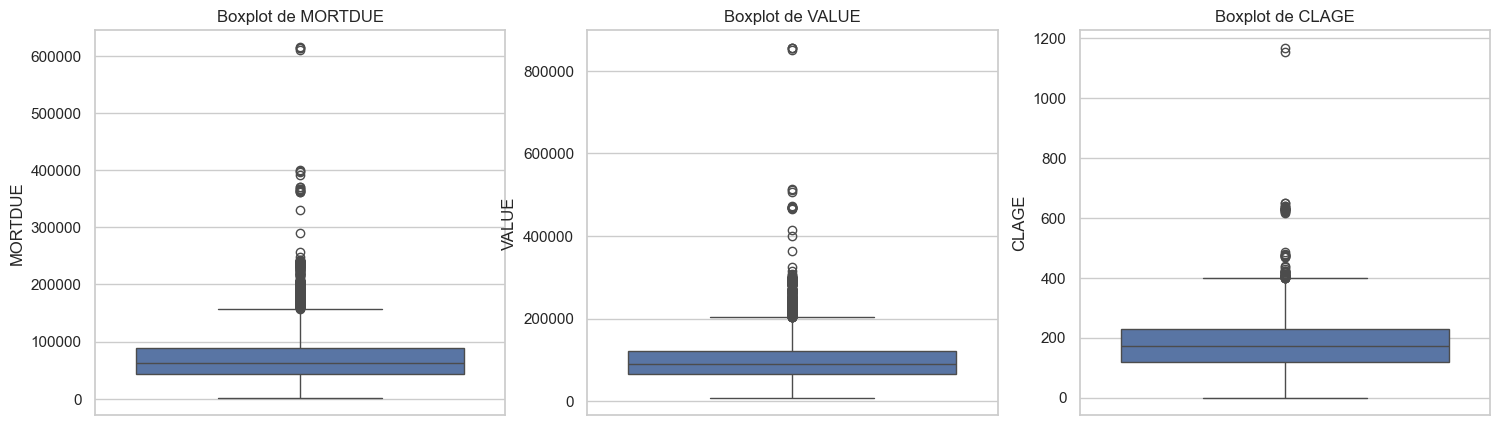

{'MORTDUE': (      BAD   LOAN   MORTDUE     VALUE   REASON      JOB     YOJ  DEROG  DELINQ  \
  140     0   4900  170986.0  245300.0  DebtCon    Sales   6.403    0.0     0.0   
  194     0   5100  179725.0  251962.0  DebtCon    Sales  10.220    0.0     0.0   
  291     0   5800  172595.0  250155.0  DebtCon    Sales   1.670    0.0     0.0   
  326     1   6000  179397.0  200000.0  DebtCon  ProfExe   5.000    6.0     0.0   
  345     0   6200  171582.0  245730.0  DebtCon    Sales   2.020    0.0     0.0   
  ...   ...    ...       ...       ...      ...      ...     ...    ...     ...   
  5925    0  69700  191972.0  294367.0  DebtCon     Self  10.000    0.0     0.0   
  5926    0  70300  197761.0  294169.0  DebtCon     Self   9.000    0.0     0.0   
  5927    0  70500  196690.0  288512.0  DebtCon     Self   9.000    0.0     0.0   
  5928    0  70800  192044.0  292380.0  DebtCon     Self  10.000    0.0     0.0   
  5929    0  71200  196601.0  289430.0  DebtCon     Self  12.000    0.0     

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Définir le style de visualisation
sns.set(style="whitegrid")

# Colonnes à analyser pour détecter les valeurs aberrantes
outlier_cols = ["MORTDUE", "VALUE", "CLAGE"]

# Tracer les boxplots pour visualiser les valeurs aberrantes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Créer une figure avec 3 sous-graphiques

# Boucle pour générer les boxplots pour chaque colonne
for i, col in enumerate(outlier_cols):
    sns.boxplot(y=df_cleaned[col], ax=axes[i])  # Créer un boxplot pour chaque colonne
    axes[i].set_title(f"Boxplot de {col}")  # Ajouter un titre au boxplot

plt.show()  # Afficher les graphiques

# Fonction pour détecter les valeurs aberrantes en utilisant la méthode IQR
def detect_outliers(df_cleaned, column):
    Q1 = df_cleaned[column].quantile(0.25)  # Calcul du premier quartile (Q1)
    Q3 = df_cleaned[column].quantile(0.75)  # Calcul du troisième quartile (Q3)
    IQR = Q3 - Q1  # Calcul de l'intervalle interquartile (IQR)
    lower_bound = Q1 - 1.5 * IQR  # Définir la limite inférieure pour les valeurs aberrantes
    upper_bound = Q3 + 1.5 * IQR  # Définir la limite supérieure pour les valeurs aberrantes
    # Identifier les lignes qui ont des valeurs en dehors des limites (valeurs aberrantes)
    outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
    return outliers, lower_bound, upper_bound  # Retourner les valeurs aberrantes, la limite inférieure et supérieure

# Détecter les valeurs aberrantes pour MORTDUE, VALUE, CLAGE
outliers_dict = {}  # Créer un dictionnaire pour stocker les résultats
for col in outlier_cols:
    outliers_dict[col] = detect_outliers(df_cleaned, col)  # Appliquer la fonction de détection des valeurs aberrantes pour chaque colonne

outliers_dict  # Afficher le dictionnaire contenant les résultats des valeurs aberrantes


In [36]:
df_cleaned['LOAN_VALID'] = df_cleaned['LOAN'] <= df_cleaned['VALUE']

In [37]:
df_cleaned['MORTDUE_VALID'] = df_cleaned['MORTDUE'] <= df_cleaned['VALUE']

In [38]:
# lignes où LOAN > VALUE
df_cleaned[df_cleaned['LOAN_VALID'] == True]
# lignes où MORTDUE > VALUE
df_cleaned[df_cleaned['MORTDUE_VALID'] == False]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,LOAN_VALID,MORTDUE_VALID


In [39]:
df_cleaned.drop(columns=['MORTDUE_VALID','LOAN_VALID' ], inplace=True)

In [40]:
# Vérifier les ratios dette/revenu excessifs (> 100%)
high_debtinc = df_cleaned[df_cleaned["DEBTINC"] > 100]
high_debtinc

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
3910,1,20500,113963.0,131135.0,HomeImp,Self,3.0,1.0,0.0,243.680604,1.0,26.0,143.949605
4423,1,23000,58577.0,69327.0,HomeImp,Other,4.0,0.0,2.0,110.414480,2.0,33.0,133.528270
4473,1,23300,103783.0,132612.0,DebtCon,Sales,1.0,0.0,0.0,120.347967,0.0,19.0,203.312149
5599,1,37300,68789.0,86172.0,HomeImp,Self,2.0,0.0,6.0,235.637906,2.0,25.0,114.050528
5912,1,65500,205156.0,290239.0,DebtCon,ProfExe,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001


In [41]:
# Suppression des lignes avec ratio dette/revenu > 100%
df_cleaned = df_cleaned[df_cleaned["DEBTINC"] <= 100]

# Vérifier les ratios dette/revenu excessifs (> 100%)
high_debtinc = df_cleaned[df_cleaned["DEBTINC"] > 100]
high_debtinc

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC


In [42]:
# Vérifier les cas où CLAGE est extrêmement élevé (> 900 mois = 75 ans)
extreme_clage = df_cleaned[df_cleaned["CLAGE"] > 900]
extreme_clage

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
3097,1,16800,87300.0,155500.0,DebtCon,Other,3.0,0.0,0.0,1154.633333,0.0,0.0,34.124877
3679,1,19300,96454.0,157809.0,DebtCon,Other,3.0,0.0,0.0,1168.233561,0.0,0.0,40.206138


In [43]:
# Suppression des lignes où CLAGE est extrêmement élevé (> 900 mois = 75 ans)
df_cleaned = df_cleaned[df_cleaned["CLAGE"] <= 900]

# Vérifier les cas où CLAGE est extrêmement élevé (> 900 mois = 75 ans)
extreme_clage = df_cleaned[df_cleaned["CLAGE"] > 900]
extreme_clage

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC


In [44]:
# Vérification des valeurs extrêmes pour MORTDUE et VALUE en relation avec d'autres variables

# Afficher les 5 plus grandes valeurs de MORTDUE et VALUE
df_sorted_mortdue = df_cleaned[["MORTDUE", "VALUE", "LOAN"]].sort_values(by="MORTDUE", ascending=False).head(10)
df_sorted_value = df_cleaned[["MORTDUE", "VALUE", "LOAN"]].sort_values(by="VALUE", ascending=False).head(10)

In [45]:
df_sorted_mortdue

,MORTDUE,VALUE,LOAN
5752,614770.0,855909.0,43500
5707,613481.0,854114.0,41700
5706,613479.0,854112.0,41700
5665,610526.0,850000.0,40000
2522,399550.0,399550.0,15000
5638,399412.0,511164.0,39000
5586,397299.0,512650.0,36600
5545,391000.0,505000.0,35000
5682,371003.0,467818.0,40700
5670,369874.0,467112.0,40300


In [46]:
df_sorted_value

,MORTDUE,VALUE,LOAN
5752,614770.0,855909.0,43500
5707,613481.0,854114.0,41700
5706,613479.0,854112.0,41700
5665,610526.0,850000.0,40000
5586,397299.0,512650.0,36600
5638,399412.0,511164.0,39000
5545,391000.0,505000.0,35000
5697,362578.0,471827.0,41400
5721,367089.0,469771.0,42300
5710,363737.0,469748.0,41800


In [47]:
# Sélectionner les 4 premières lignes à supprimer
rows_to_remove = df_cleaned[["MORTDUE", "VALUE", "LOAN"]].sort_values(by="MORTDUE", ascending=False).head(4)

# Supprimer ces lignes de df_cleaned
df_cleaned = df_cleaned.drop(rows_to_remove.index)


In [48]:
# Vérification des valeurs extrêmes pour CLAGE et DEBTINC
df_sorted_clage = df_cleaned[["CLAGE", "MORTDUE", "VALUE", "LOAN"]].sort_values(by="CLAGE", ascending=False).head(10)
df_sorted_debtinc = df_cleaned[["DEBTINC", "MORTDUE", "VALUE", "LOAN"]].sort_values(by="DEBTINC", ascending=False).head(10)


In [49]:
df_sorted_clage

,CLAGE,MORTDUE,VALUE,LOAN
4470,649.747104,61496.0,102823.0,23300
4536,648.328493,57553.0,101656.0,23700
4264,639.058172,64809.0,96831.0,22200
4238,638.275361,61042.0,96622.0,22000
3928,634.461893,64113.0,98322.0,20500
3856,632.103186,61303.0,97780.0,20200
3787,630.033333,56135.0,93234.0,20000
4417,629.095766,58696.0,102176.0,23000
4390,628.981948,62754.0,101781.0,22800
4262,628.158062,57458.0,102195.0,22200


In [50]:
df_sorted_debtinc

,DEBTINC,MORTDUE,VALUE,LOAN
2283,91.612600,144263.0,167164.0,13900
5155,84.613889,61396.0,111627.0,27700
3713,84.379034,94419.0,123705.0,19600
3455,78.654386,95091.0,113294.0,18200
5045,76.421478,138216.0,170052.0,26800
216,72.670433,40564.0,40564.0,5200
1601,72.264093,57939.0,69774.0,11600
5046,71.512111,18459.0,53907.0,26800
414,69.800525,183860.0,208910.0,6500
1633,69.480650,63914.0,93707.0,11700


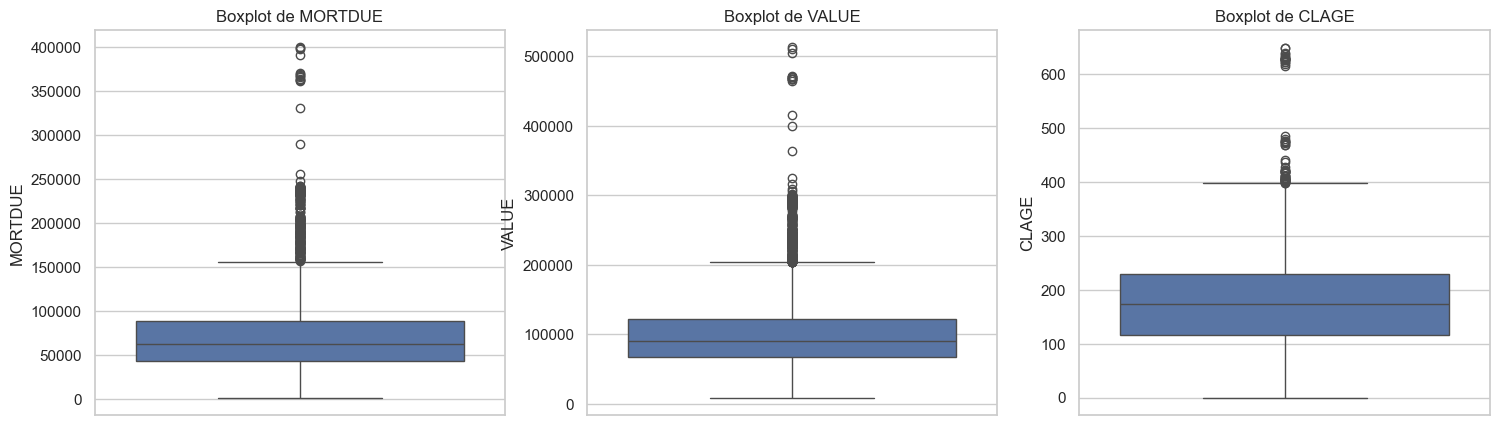

{'MORTDUE': (      BAD   LOAN   MORTDUE     VALUE   REASON      JOB     YOJ  DEROG  DELINQ  \
  140     0   4900  170986.0  245300.0  DebtCon    Sales   6.403    0.0     0.0   
  194     0   5100  179725.0  251962.0  DebtCon    Sales  10.220    0.0     0.0   
  291     0   5800  172595.0  250155.0  DebtCon    Sales   1.670    0.0     0.0   
  326     1   6000  179397.0  200000.0  DebtCon  ProfExe   5.000    6.0     0.0   
  345     0   6200  171582.0  245730.0  DebtCon    Sales   2.020    0.0     0.0   
  ...   ...    ...       ...       ...      ...      ...     ...    ...     ...   
  5925    0  69700  191972.0  294367.0  DebtCon     Self  10.000    0.0     0.0   
  5926    0  70300  197761.0  294169.0  DebtCon     Self   9.000    0.0     0.0   
  5927    0  70500  196690.0  288512.0  DebtCon     Self   9.000    0.0     0.0   
  5928    0  70800  192044.0  292380.0  DebtCon     Self  10.000    0.0     0.0   
  5929    0  71200  196601.0  289430.0  DebtCon     Self  12.000    0.0     

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Définir le style de visualisation
sns.set(style="whitegrid")

# Colonnes à analyser pour détecter les valeurs aberrantes (outliers)
outlier_cols = ["MORTDUE", "VALUE", "CLAGE"]

# Créer un graphique avec des boxplots pour visualiser les valeurs aberrantes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Création de 3 sous-graphiques pour les colonnes spécifiées

# Générer un boxplot pour chaque colonne de outlier_cols
for i, col in enumerate(outlier_cols):
    sns.boxplot(y=df_cleaned[col], ax=axes[i])  # Création du boxplot pour chaque colonne
    axes[i].set_title(f"Boxplot de {col}")  # Définir le titre du graphique

plt.show()  # Afficher le graphique

# Fonction pour détecter les valeurs aberrantes en utilisant la méthode de l'IQR (Interquartile Range)
def detect_outliers(df_cleaned, column):
    Q1 = df_cleaned[column].quantile(0.25)  # Premier quartile (Q1)
    Q3 = df_cleaned[column].quantile(0.75)  # Troisième quartile (Q3)
    IQR = Q3 - Q1  # Calcul de l'IQR
    lower_bound = Q1 - 1.5 * IQR  # Limite inférieure pour les outliers
    upper_bound = Q3 + 1.5 * IQR  # Limite supérieure pour les outliers
    outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]  # Détection des outliers
    return outliers, lower_bound, upper_bound  # Retourner les outliers et les limites

# Détecter les valeurs aberrantes dans les colonnes MORTDUE, VALUE et CLAGE
outliers_dict = {}  # Dictionnaire pour stocker les résultats
for col in outlier_cols:
    outliers_dict[col] = detect_outliers(df_cleaned, col)  # Appliquer la fonction de détection sur chaque colonne

outliers_dict  # Afficher les résultats des outliers pour chaque colonne


In [52]:
df_okmortdue = df_cleaned[["MORTDUE"]].sort_values(by="MORTDUE", ascending=False).head(10)
df_okmortdue

,MORTDUE
2522,399550.0
5638,399412.0
5586,397299.0
5545,391000.0
5682,371003.0
5670,369874.0
5742,367917.0
5721,367089.0
5702,365528.0
5710,363737.0


In [53]:
# afficher les 20 premières valeurs de CLAGE dans l'ordre décroissant
df_okclage = df_cleaned[["CLAGE"]].sort_values(by="CLAGE", ascending=False).head(20)
df_okclage

,CLAGE
4470,649.747104
4536,648.328493
4264,639.058172
4238,638.275361
3928,634.461893
3856,632.103186
3787,630.033333
4417,629.095766
4390,628.981948
4262,628.158062


In [54]:
# Supprimer les lignes où 'CLAGE' est supérieur à 615 (~51 ans)
rows_to_remove = df_cleaned[["CLAGE"]].sort_values(by="CLAGE", ascending=False).head(18)

# Supprimer ces lignes de df_cleaned
df_cleaned = df_cleaned.drop(rows_to_remove.index)

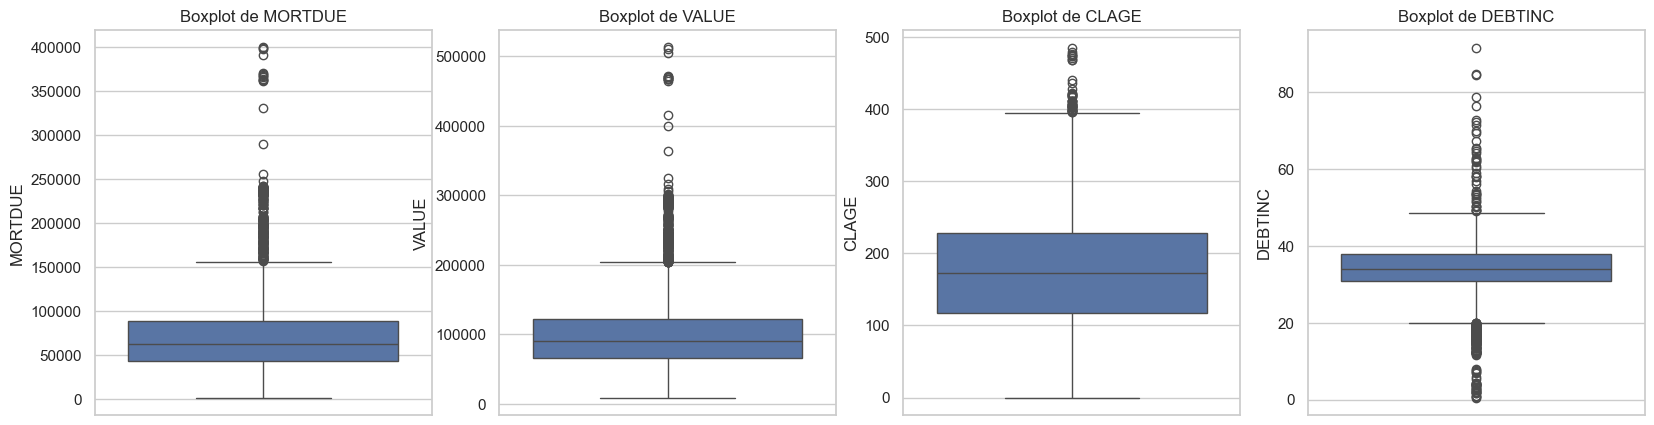

{'MORTDUE': (      BAD   LOAN   MORTDUE     VALUE   REASON      JOB     YOJ  DEROG  DELINQ  \
  140     0   4900  170986.0  245300.0  DebtCon    Sales   6.403    0.0     0.0   
  194     0   5100  179725.0  251962.0  DebtCon    Sales  10.220    0.0     0.0   
  291     0   5800  172595.0  250155.0  DebtCon    Sales   1.670    0.0     0.0   
  326     1   6000  179397.0  200000.0  DebtCon  ProfExe   5.000    6.0     0.0   
  345     0   6200  171582.0  245730.0  DebtCon    Sales   2.020    0.0     0.0   
  ...   ...    ...       ...       ...      ...      ...     ...    ...     ...   
  5925    0  69700  191972.0  294367.0  DebtCon     Self  10.000    0.0     0.0   
  5926    0  70300  197761.0  294169.0  DebtCon     Self   9.000    0.0     0.0   
  5927    0  70500  196690.0  288512.0  DebtCon     Self   9.000    0.0     0.0   
  5928    0  70800  192044.0  292380.0  DebtCon     Self  10.000    0.0     0.0   
  5929    0  71200  196601.0  289430.0  DebtCon     Self  12.000    0.0     

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Définir le style de visualisation
sns.set(style="whitegrid")

# Colonnes à analyser pour détecter les valeurs aberrantes (outliers)
outlier_cols = ["MORTDUE", "VALUE", "CLAGE", "DEBTINC"]

# Créer des boxplots pour visualiser les valeurs aberrantes
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Créer une figure avec 4 sous-graphes côte à côte

# Pour chaque colonne, tracer un boxplot
for i, col in enumerate(outlier_cols):
    sns.boxplot(y=df_cleaned[col], ax=axes[i])  # Tracer un boxplot pour chaque colonne
    axes[i].set_title(f"Boxplot de {col}")  # Ajouter un titre pour chaque boxplot

plt.show()  # Afficher les graphiques

# Fonction pour détecter les valeurs aberrantes à l'aide de la méthode de l'IQR (Interquartile Range)
def detect_outliers(df_cleaned, column):
    Q1 = df_cleaned[column].quantile(0.25)  # Premier quartile
    Q3 = df_cleaned[column].quantile(0.75)  # Troisième quartile
    IQR = Q3 - Q1  # Calcul de l'IQR
    lower_bound = Q1 - 1.5 * IQR  # Seuil inférieur (1.5 fois l'IQR en dessous de Q1)
    upper_bound = Q3 + 1.5 * IQR  # Seuil supérieur (1.5 fois l'IQR au-dessus de Q3)
    
    # Identifier les lignes où les valeurs sont en dehors des bornes définies
    outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
    return outliers, lower_bound, upper_bound  # Retourner les valeurs aberrantes ainsi que les bornes

# Détecter les valeurs aberrantes dans les colonnes 'MORTDUE', 'VALUE', 'CLAGE', 'DEBTINC'
outliers_dict = {}
for col in outlier_cols:
    outliers_dict[col] = detect_outliers(df_cleaned, col)  # Appliquer la fonction de détection pour chaque colonne

outliers_dict  # Afficher les résultats des valeurs aberrantes détectées pour chaque colonne


In [56]:
# afficher les 10 premières valeurs de DEBTINC dans l'ordre décroissant
df_okdebtinc = df_cleaned[["DEBTINC"]].sort_values(by="DEBTINC", ascending=False).head(10)
df_okdebtinc

,DEBTINC
2283,91.612600
5155,84.613889
3713,84.379034
3455,78.654386
5045,76.421478
216,72.670433
1601,72.264093
5046,71.512111
414,69.800525
1633,69.480650


In [57]:
# supprimer les lignes dont les valeurs dans les 8 premières colonnes 
rows_to_remove = df_cleaned[["DEBTINC"]].sort_values(by="DEBTINC", ascending=False).head(8)

# Supprimer ces lignes de df_cleaned
df_cleaned = df_cleaned.drop(rows_to_remove.index)

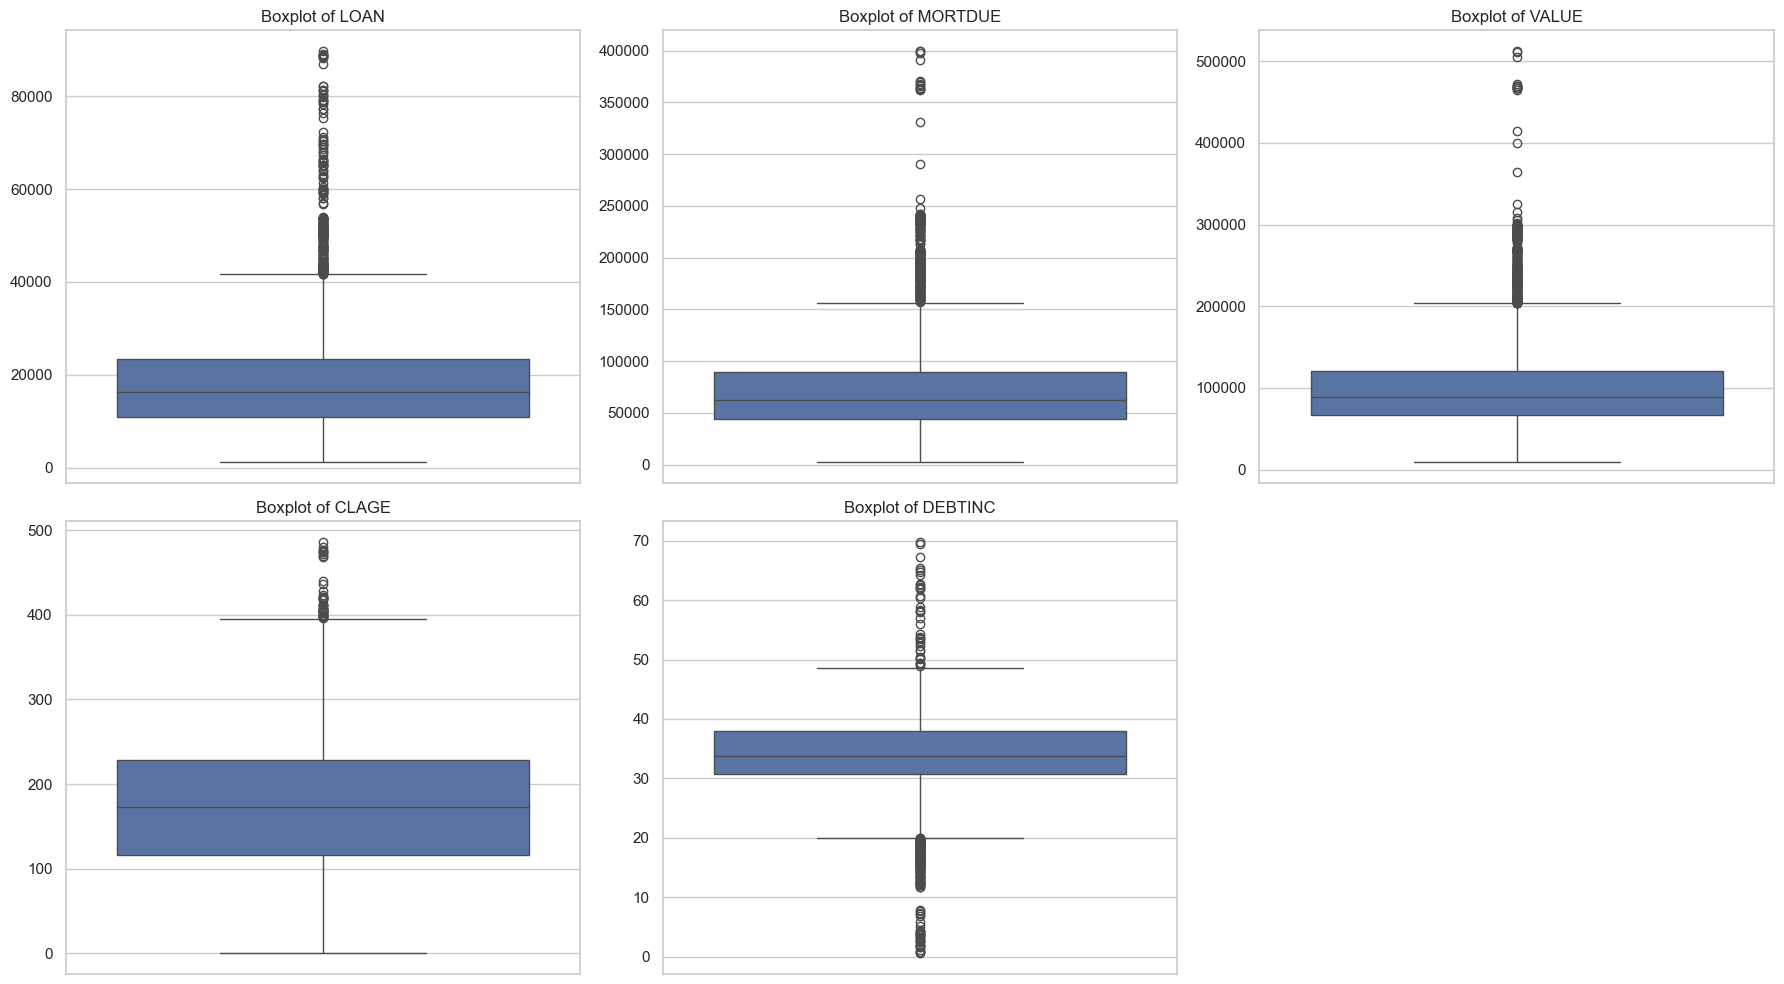

{'LOAN': (      BAD   LOAN   MORTDUE     VALUE   REASON      JOB    YOJ  DEROG  DELINQ  \
  5708    1  41800  147416.0  227168.0  DebtCon     Self   2.00    0.0     4.0   
  5709    0  41800    5143.0   67205.0  HomeImp   Office  15.09    0.0     0.0   
  5710    0  41800  363737.0  469748.0  HomeImp  ProfExe   4.00    0.0     0.0   
  5711    1  42000    9999.0   50681.0  HomeImp  ProfExe   3.00    0.0     0.0   
  5712    0  42000   21314.0   68047.0  DebtCon    Other  21.00    0.0     0.0   
  ...   ...    ...       ...       ...      ...      ...    ...    ...     ...   
  5954    0  88900   48919.0   93371.0  DebtCon    Other  15.00    0.0     1.0   
  5955    0  88900   57264.0   90185.0  DebtCon    Other  16.00    0.0     0.0   
  5956    0  89000   54576.0   92937.0  DebtCon    Other  16.00    0.0     0.0   
  5957    0  89200   54045.0   92924.0  DebtCon    Other  15.00    0.0     0.0   
  5958    0  89800   50370.0   91861.0  DebtCon    Other  14.00    0.0     0.0   
  
     

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Définir le style de visualisation
sns.set(style="whitegrid")  # Utilisation d'un fond avec une grille blanche pour la visualisation

# Colonnes à analyser pour les valeurs aberrantes (outliers)
outlier_cols = ["LOAN", "MORTDUE", "VALUE", "CLAGE", "DEBTINC"]

# Créer les boxplots pour visualiser les valeurs aberrantes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Ajuster la disposition des graphiques (2 lignes, 3 colonnes)

# Aplatir le tableau d'axes pour un accès plus facile
axes = axes.flatten()

# Boucle sur chaque colonne pour tracer un boxplot
for i, col in enumerate(outlier_cols):
    sns.boxplot(y=df_cleaned[col], ax=axes[i])  # Tracer un boxplot pour chaque colonne
    axes[i].set_title(f"Boxplot of {col}")  # Ajouter un titre à chaque boxplot
    axes[i].set_ylabel('')  # Retirer le label de l'axe y pour une meilleure esthétique
    axes[i].set_xlabel('')  # Retirer le label de l'axe x pour une meilleure esthétique

# Supprimer le subplot vide (en bas à droite) si le nombre de graphiques est inférieur à 6
for j in range(len(outlier_cols), len(axes)):
    fig.delaxes(axes[j])  # Supprimer l'axe inutile

plt.tight_layout()  # S'assurer qu'il n'y a pas de chevauchement entre les éléments et que la disposition est propre
plt.show()  # Afficher les graphiques

# Fonction pour détecter les valeurs aberrantes en utilisant la méthode IQR (Intervalle Interquartile)
def detect_outliers(df_cleaned, column):
    Q1 = df_cleaned[column].quantile(0.25)  # Premier quartile (Q1)
    Q3 = df_cleaned[column].quantile(0.75)  # Troisième quartile (Q3)
    IQR = Q3 - Q1  # Calcul de l'intervalle interquartile
    lower_bound = Q1 - 1.5 * IQR  # Limite inférieure pour détecter les outliers
    upper_bound = Q3 + 1.5 * IQR  # Limite supérieure pour détecter les outliers
    # Sélectionner les lignes qui ont des valeurs en dehors des limites
    outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
    return outliers, lower_bound, upper_bound  # Retourner les valeurs aberrantes et les limites

# Détecter les valeurs aberrantes dans les colonnes spécifiées
outliers_dict = {}  # Dictionnaire pour stocker les résultats
for col in outlier_cols:
    outliers_dict[col] = detect_outliers(df_cleaned, col)  # Ajouter les résultats pour chaque colonne

outliers_dict  # Afficher les résultats pour toutes les colonnes


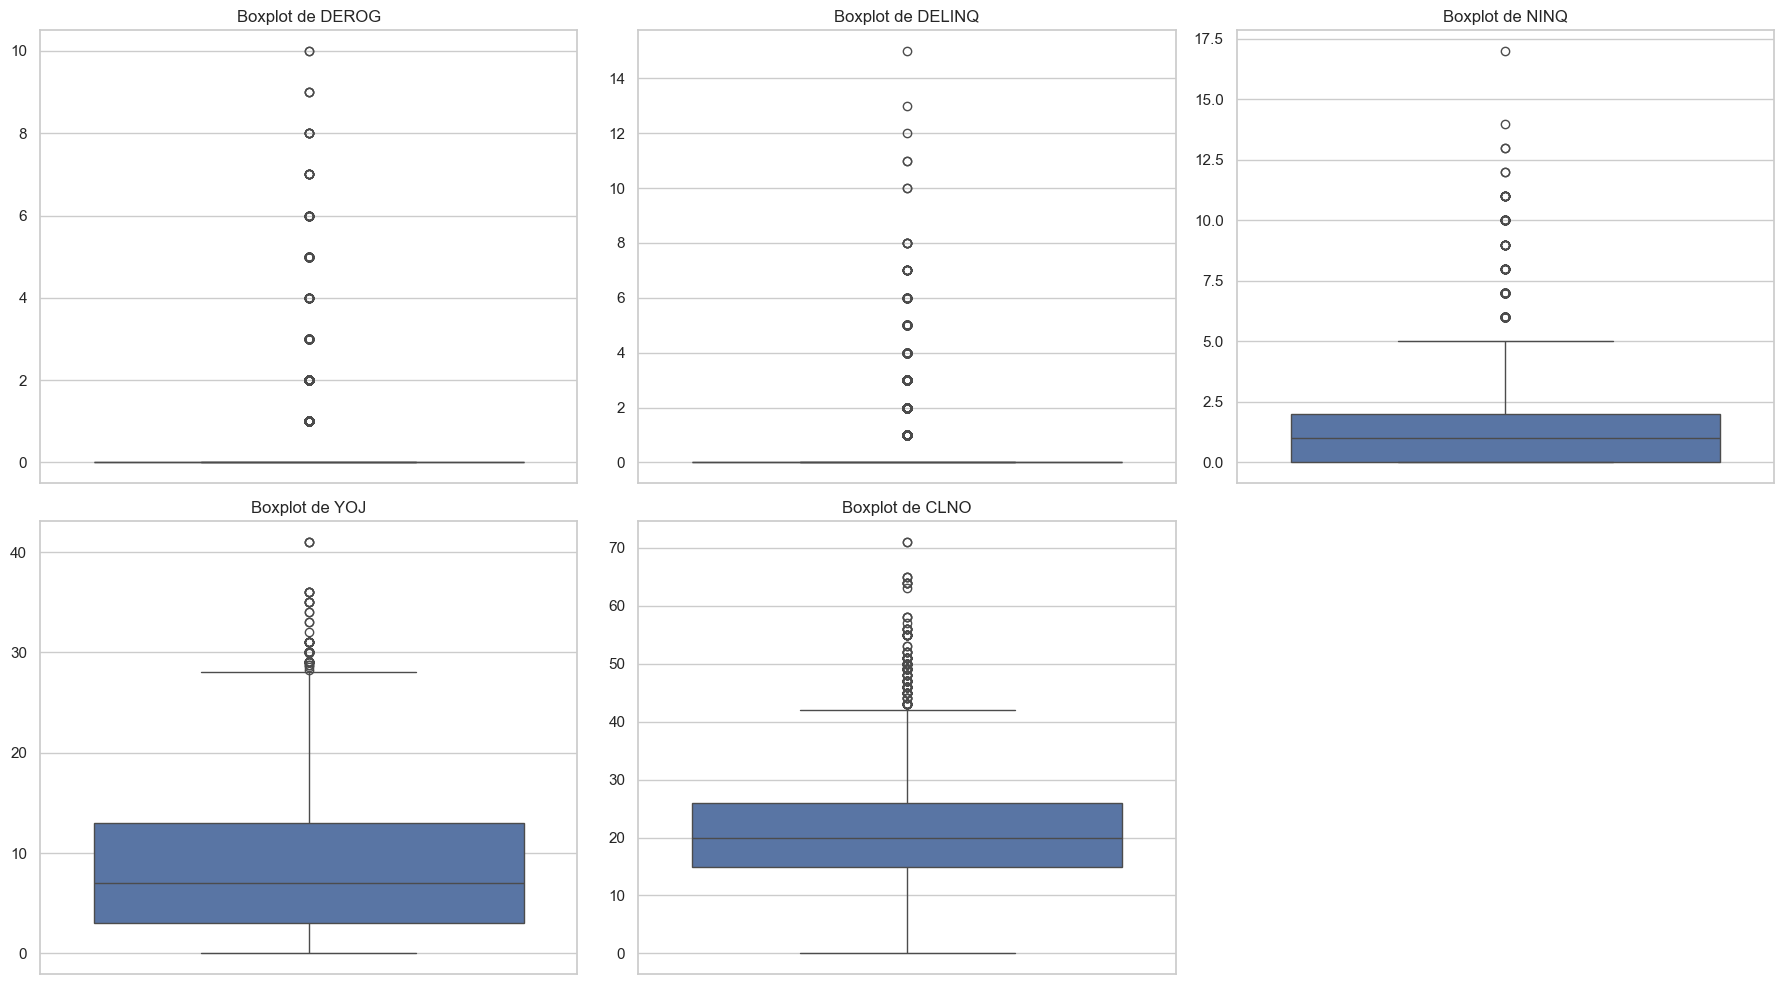

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Définir le style des graphiques
sns.set(style="whitegrid")

# Liste des colonnes à tracer
cols = ["DEROG", "DELINQ", "NINQ", "YOJ", "CLNO"]

# Créer des boxplots pour visualiser les valeurs aberrantes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Disposition ajustée en 2 lignes et 3 colonnes

# Aplatir le tableau d'axes pour un indexage plus facile
axes = axes.flatten()

# Boucle pour créer un boxplot pour chaque colonne
for i, col in enumerate(cols):
    sns.boxplot(y=df_cleaned[col], ax=axes[i])  # Tracer le boxplot pour la colonne en cours
    axes[i].set_title(f"Boxplot de {col}")  # Définir le titre du graphique
    axes[i].set_ylabel('')  # Supprimer le label de l'axe y pour une meilleure esthétique
    axes[i].set_xlabel('')  # Supprimer le label de l'axe x pour une meilleure esthétique

# Supprimer le graphique vide (en bas à droite) s'il y a moins de 6 graphiques
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])  # Supprimer les axes inutilisés

plt.tight_layout()  # Assure qu'il n'y a pas de chevauchement et rend le graphique plus propre
plt.show()  # Afficher le graphique

plt.show()  # Afficher de nouveau le graphique (double appel pour s'assurer qu'il est bien visible)


In [60]:
df_okderog = df_cleaned[["DEROG"]].sort_values(by=["DEROG"], ascending=False)
# Pour chaque valeur de DEROG, comptez le nombre de fois qu'elle apparaît.
df_okderog['DEROG'].value_counts()



DEROG
0.0     5114
1.0      460
2.0      170
3.0       59
5.0       49
6.0       25
4.0       23
7.0        8
8.0        6
9.0        3
10.0       2
Name: count, dtype: int64

In [61]:
# Pour les valeurs de DEROG supérieures à 3, limitez-les à 3.
df_cleaned.loc[df_cleaned['DEROG'] > 3, 'DEROG'] = 3

In [62]:
df_okninq = df_cleaned[["NINQ"]].sort_values(by=["NINQ"], ascending=False)

df_okninq['NINQ'].value_counts()



NINQ
0.000000     2511
1.000000     1321
2.000000      778
1.186743      510
3.000000      392
4.000000      156
5.000000       74
6.000000       56
7.000000       44
10.000000      28
8.000000       22
9.000000       11
11.000000      10
12.000000       2
13.000000       2
14.000000       1
17.000000       1
Name: count, dtype: int64

In [63]:
# Pour les valeurs de NINQ supérieures à 6, limitez-les à 6.
df_cleaned.loc[df_cleaned['NINQ'] > 6, 'NINQ'] = 6

In [64]:
df_okdeliq = df_cleaned[["DELINQ"]].sort_values(by=["DELINQ"], ascending=False)

df_okdeliq['DELINQ'].value_counts()


DELINQ
0.0     4535
1.0      758
2.0      302
3.0      131
4.0       78
5.0       55
6.0       35
7.0       13
8.0        5
11.0       2
10.0       2
15.0       1
13.0       1
12.0       1
Name: count, dtype: int64

In [65]:
# Pour les valeurs de DELINQ supérieures à 4, limitez-les à 4.
df_cleaned.loc[df_cleaned['DELINQ'] > 4, 'DELINQ'] = 4


In [66]:
# Compter les valeurs de 'CLNO' et trier les plus élevées
df_cleaned['CLNO'].sort_values(ascending=False).head(20)

# Supprimer les 2 premières valeurs les plus élevées de 'CLNO'
df_cleaned = df_cleaned.drop(df_cleaned['CLNO'].sort_values(ascending=False).head(2).index)


In [67]:

# Compter les valeurs de 'YOJ' et trier les plus élevées
df_cleaned['YOJ'].sort_values(ascending=False).head(20)

# Supprimer les 3 premières valeurs les plus élevées de 'YOJ'
df_cleaned = df_cleaned.drop(df_cleaned['YOJ'].sort_values(ascending=False).head(3).index)

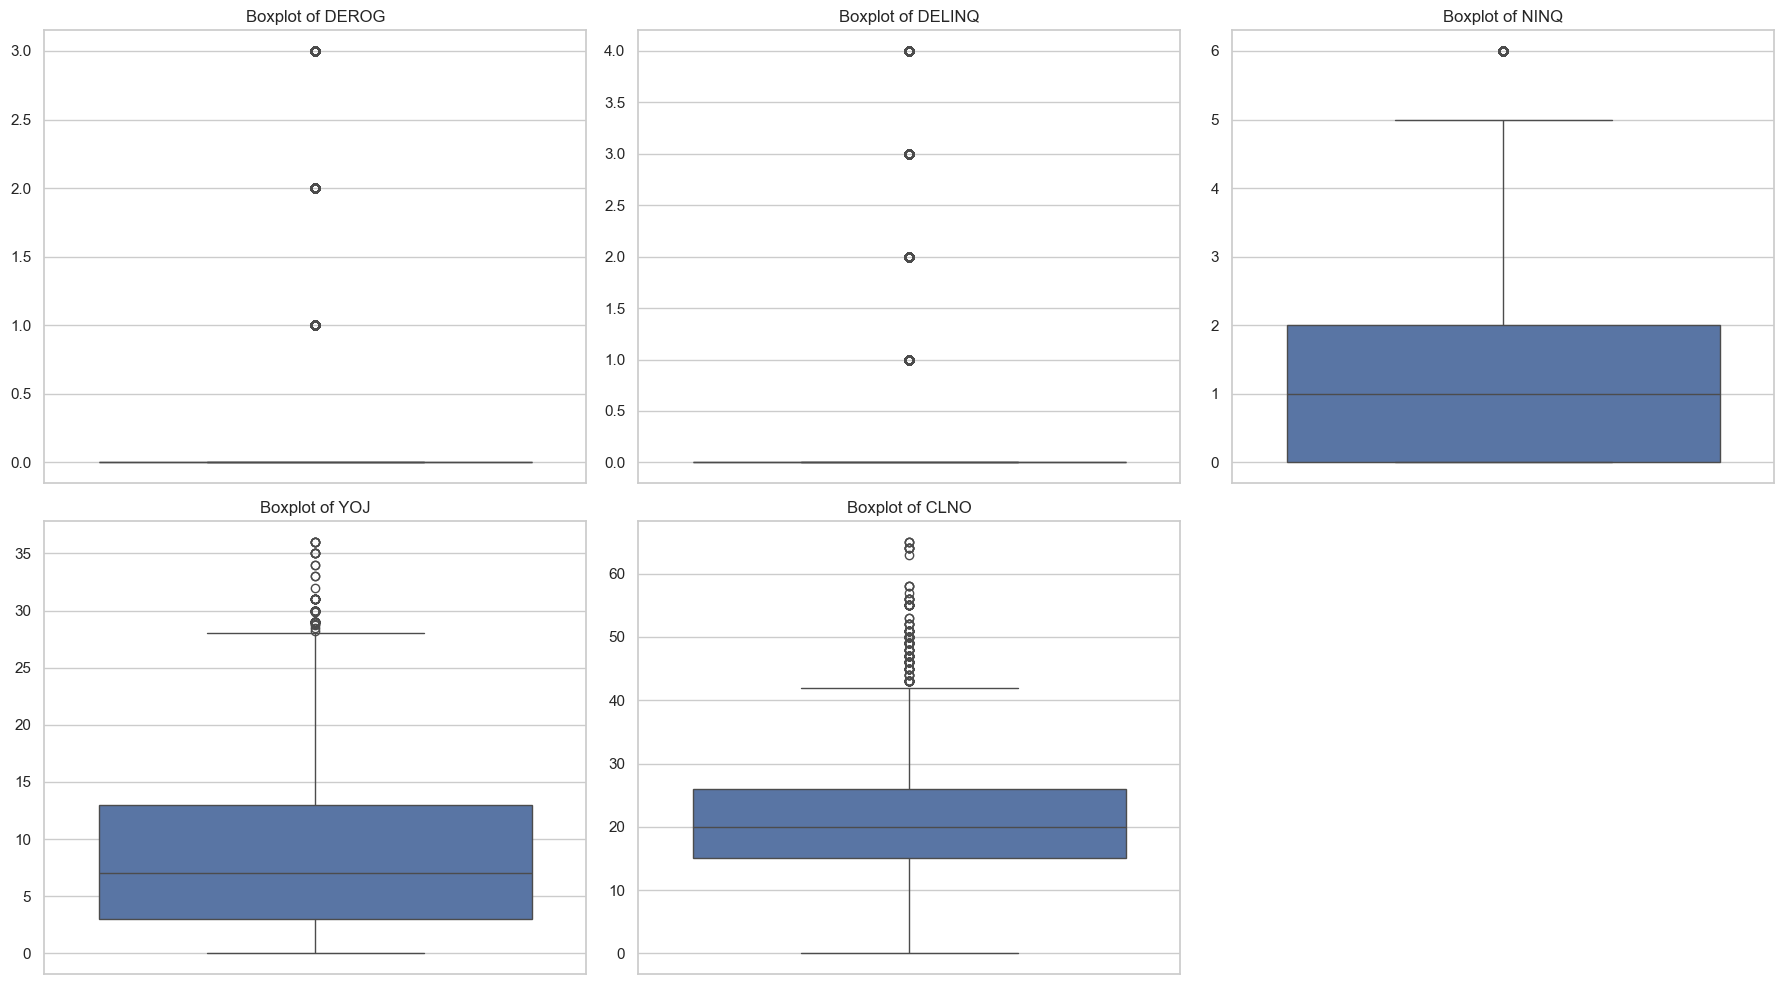

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Définir le style de la grille
sns.set(style="whitegrid")

# Liste des colonnes à afficher
cols = ["DEROG", "DELINQ", "NINQ", "YOJ", "CLNO"]

# Créer des boxplots pour visualiser les valeurs aberrantes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Disposition ajustée pour 2 lignes et 3 colonnes

# Aplatir l'array des axes pour faciliter l'indexation
axes = axes.flatten()

# Créer un boxplot pour chaque colonne spécifiée
for i, col in enumerate(cols):
    sns.boxplot(y=df_cleaned[col], ax=axes[i])  # Tracer le boxplot pour la colonne actuelle
    axes[i].set_title(f"Boxplot of {col}")  # Titre du graphique
    axes[i].set_ylabel('')  # Supprimer le label de l'axe y pour une meilleure esthétique
    axes[i].set_xlabel('')  # Supprimer le label de l'axe x pour une meilleure esthétique

# Supprimer le subplot vide (en bas à droite) si moins de 6 graphiques sont présents
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Ajuste l'agencement pour éviter les chevauchements et rendre le graphique plus propre
plt.show()  # Affiche le graphique

plt.show()  # Affiche le graphique (encore une fois, cette ligne est redondante)


In [69]:
# Vérifier si le répertoire existe avant de sauvegarder
output_dir = "./Dataset"  # Définir le répertoire de sortie
os.makedirs(output_dir, exist_ok=True)  # Créer le répertoire s'il n'existe pas déjà, sans erreur

# Sauvegarder le dataframe nettoyé dans un fichier CSV
df_cleaned.to_csv(f"{output_dir}/hmeq_clean_miticulous.csv", index=False)  # Enregistrer sans l'index


In [70]:
var_num = ['LOAN',"MORTDUE", "VALUE", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO", "DEBTINC"]

global_outliers_dict = {}
def detect_outliers_iqr(data, column):

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    num_outliers = len(outliers)

    global_outliers_dict[column] = num_outliers

for var in var_num:
    detect_outliers_iqr(df_cleaned, var)

df_outliers_values = pd.DataFrame.from_dict(global_outliers_dict, orient='index', columns=['Outliers'])


print(df_outliers_values)
px.bar(df_outliers_values,
       labels = {'value':"Nombre d'Outliers",'index':'Variables'},
       title = "Nombre d'Outliers dans chaque colonnes numériques avec la méthode de l'IQR")


         Outliers
LOAN          246
MORTDUE       237
VALUE         316
YOJ            91
DEROG         805
DELINQ       1381
CLAGE          44
NINQ          177
CLNO          217
DEBTINC       231
